In [21]:
from sklearn.metrics import  roc_auc_score, classification_report
from sklearn.model_selection import train_test_split

import pandas as pd
from fastparquet import ParquetFile
import numpy as np

import shap
from utils import feature_drop, remove_highly_correlated_features, get_shap_feature, get_categorical_columns

from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
import lightgbm as lgb

import seaborn as sns
import matplotlib.pyplot as plt
colors = ["#A115FE", "#8F00FF", "#4d0585", "#591878", "#6e1f78", "#7b469c", "#2c0652",
          "#29AB50", "#22753b", "#ECE919", "#7a781d", "#0F91D0", "#0f3f75"]
sns.set_palette(sns.color_palette(colors))

In [2]:
file_path = "Data/train_ai_comp_final_dp.parquet"
pf = ParquetFile(file_path)
df = pf.to_pandas()
df = feature_drop(df)
df.head()

,id,target,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,...,feature1067,feature1068,feature1069,feature1070,feature1071,feature1072,feature1073,feature1074,feature1075,feature1076
0,0,0,1761,1759,85,105469,191,46,0,6,...,28913,48985,84264,12045,12107,12510,21126,28913,48985,84264
1,1,0,1761,1759,120,105610,144,71,0,135,...,0,0,0,0,0,0,0,0,0,0
2,2,0,890,1759,141,105227,191,11,0,0,...,55949,70006,113317,33735,31242,12691,48682,55949,70006,113317
5,5,0,1599,966,30,102441,191,8,0,0,...,0,6872,8530,0,0,0,0,0,6872,8530
6,6,0,1761,1759,85,104006,191,2,0,0,...,0,0,7642,0,0,0,0,0,0,7642


In [3]:
X = df.drop(columns=['target', "id"])
y = df['target']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [4]:
X_train.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature1067,feature1068,feature1069,feature1070,feature1071,feature1072,feature1073,feature1074,feature1075,feature1076
305172,408,260,141,94228,191,71,0,16,16,0,...,0,0,0,0,0,0,0,0,0,0
180948,1618,1759,76,104221,116,30,0,88,0,0,...,0,0,136043,0,0,0,0,0,0,136043
319360,1650,844,115,105356,15,15,0,10,117,0,...,0,0,0,0,0,0,0,0,0,0
9967,1761,1759,141,46077,191,7,125,290,298,176,...,77026,110780,161867,34905,45974,46056,61544,77026,110780,161867
336341,1712,827,97,101763,191,5,125,290,298,176,...,52359,78713,122688,25856,19395,32335,36397,52359,78713,122688


In [5]:
classifiers = [
    lgb.LGBMClassifier(n_estimators=100, random_state=42, max_depth=8, learning_rate=0.01),
    XGBClassifier(n_estimators=100, random_state=42, max_depth=8, learning_rate=0.01),
    CatBoostClassifier(iterations=100, learning_rate=0.01, depth=8, loss_function='Logloss', verbose=500)
]
shap_df  = get_shap_feature(X_train, y_train, X_val, classifiers)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13005, number of negative: 350725
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.969556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136938
[LightGBM] [Info] Number of data points in the train set: 363730, number of used features: 966
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035755 -> initscore=-3.294669
[LightGBM] [Info] Start training from score -3.294669


c:\Users\Александр\Desktop\УЧЕБА\ХАКАТОНЫ\IT Purple Hack\purple_hack\venv\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


0:	learn: 0.6777218	total: 489ms	remaining: 48.4s
99:	learn: 0.1830841	total: 37.8s	remaining: 0us


In [6]:
shap_df.sort_values(by = "shap_importance", ascending = False)

,feature,shap_importance
720,feature994,8.238807e-02
258,feature341,6.780654e-02
242,feature319,3.963647e-02
7,feature1004,3.886407e-02
671,feature920,2.167598e-02
...,...,...
189,feature255,4.335998e-07
224,feature302,3.197617e-07
206,feature28,3.167174e-07
235,feature312,1.975916e-07


In [7]:
feature = shap_df["feature"].values
X_test, X_train, X_val = X_test[feature], X_train[feature], X_val[feature]

In [8]:
without_drop = shap_df.sort_values(by = "shap_importance", ascending = False)["feature"].head(10)
without_drop.values

array(['feature994', 'feature341', 'feature319', 'feature1004',
       'feature920', 'feature953', 'feature954', 'feature940',
       'feature320', 'feature952'], dtype=object)

In [9]:
columns_to_remove = remove_highly_correlated_features(X_train.drop(columns=without_drop.values), shap_df, threshold=0.95)

In [10]:
X_train, X_val, X_test = X_train.drop(columns=columns_to_remove), X_val.drop(columns=columns_to_remove),  X_test.drop(columns=columns_to_remove)

In [11]:
category = get_categorical_columns(X_train)

In [12]:
len(category)

63

In [13]:
set1 = set(category)
set2 = set(X_train.columns)

is_subset = set1.issubset(set2)

is_subset

True

In [14]:
model = CatBoostClassifier(iterations=500, learning_rate=0.01, depth=8, loss_function='Logloss', verbose = 100)
model.fit(X_train, y_train, cat_features=category)

y_train_pred = model.predict_proba(X_train)[:, 1]
y_val_pred = model.predict_proba(X_val)[:, 1]

predictions = np.where(y_val_pred > 0.05, 1, 0)

roc_auc_train = roc_auc_score(y_train, y_train_pred)
roc_auc_test = roc_auc_score(y_val, y_val_pred)
print(f"roc-auc train {roc_auc_train}")
print(f"roc-auc test {roc_auc_test}")
print(classification_report(y_val, predictions))

0:	learn: 0.6775254	total: 845ms	remaining: 7m 1s
100:	learn: 0.1818819	total: 1m 41s	remaining: 6m 39s
200:	learn: 0.1455802	total: 3m 32s	remaining: 5m 16s
300:	learn: 0.1396690	total: 5m 18s	remaining: 3m 30s
400:	learn: 0.1376135	total: 6m 58s	remaining: 1m 43s
499:	learn: 0.1363126	total: 8m 36s	remaining: 0us
roc-auc train 0.7613605667548264
roc-auc test 0.7380545380307937
              precision    recall  f1-score   support

           0       0.98      0.83      0.90     75207
           1       0.09      0.48      0.16      2735

    accuracy                           0.82     77942
   macro avg       0.54      0.66      0.53     77942
weighted avg       0.95      0.82      0.87     77942



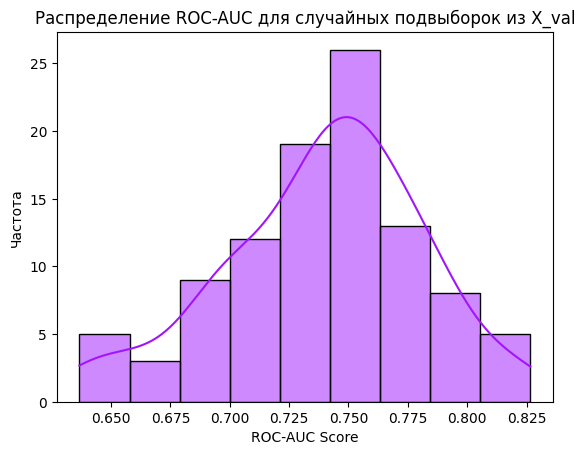

5-й квантиль: 0.6624608183697914
95-й квантиль: 0.79343134857206


In [32]:
seed = 42
rng = np.random.RandomState(seed)

roc_auc_scores = []

for _ in range(100):  # Повторяем 100 раз
    # Выбираем случайные 1000 элементов из X_val и соответствующие метки y_val с помощью созданного генератора
    sample_indices = rng.choice(X_val.index, size=1000, replace=False)
    X_val_sample = X_val.loc[sample_indices]
    y_val_sample = y_val.loc[sample_indices]
    
    # Выполняем предсказание для выборки
    y_pred_sample = model.predict_proba(X_val_sample)[:, 1]
    
    # Вычисляем roc_auc и добавляем в список
    roc_auc = roc_auc_score(y_val_sample, y_pred_sample)
    roc_auc_scores.append(roc_auc)

# Визуализация распределения roc_auc с помощью гистограммы
sns.histplot(roc_auc_scores, kde=True)
plt.title('Распределение ROC-AUC для случайных подвыборок из X_val')
plt.xlabel('ROC-AUC Score')
plt.ylabel('Частота')
plt.show()

# Вычисление 5-го и 95-го квантилей
quantile_5 = np.percentile(roc_auc_scores, 5)
quantile_95 = np.percentile(roc_auc_scores, 95)

print(f"5-й квантиль: {quantile_5}")
print(f"95-й квантиль: {quantile_95}")